# Install Transformers Library

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 1.1MB 15.9MB/s 
     |████████████████████████████████| 890kB 18.2MB/s 
     |████████████████████████████████| 3.0MB 43.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3412295a301b13ff877c2955a436cfac8b730258f1168418fc97fa30647d8fec
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

'Cambridge important dates.gsheet'   Notability
'Colab Notebooks'		    'S7 Survey.gform'
 CS3244				     Shared
 cs3244_tut02_questions.pdf	    'Untitled document.gdoc'
 GitHub				    '弟子规班 谨08 Feedback.gform'
'Grading Review 22 9.gdoc'	    '谨 09 final.pptx'
 Modules


In [ ]:
pos_sample = pd.read_csv("/content/drive/My Drive/CS3244/ISOT/True.csv")
pos_sample['label'] = [1] * pos_sample.shape[0]
pos_sample.drop(columns=['subject', 'date'])
pos_sample.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
neg_sample = pd.read_csv("/content/drive/My Drive/CS3244/ISOT/Fake.csv")
neg_sample['label'] = [0] * neg_sample.shape[0]
neg_sample.drop(columns=['subject', 'date'])
neg_sample.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
df = pd.concat([pos_sample, neg_sample], ignore_index=True, sort=False)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df.shape

(44898, 5)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.522985
1    0.477015
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2020, 
                                                                    test_size=0.2, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2020, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

In [ ]:
train_text

21270    BRUSSELS (Reuters) - EU chief executive Jean-C...
15453    SEOUL (Reuters) - President Donald Trump on Tu...
8036     WASHINGTON (Reuters) - The New York Times endo...
43027    The children were greeted at the Capitol steps...
17301    KIGALI (Reuters) - A critic of Rwandan Preside...
                               ...                        
9492     WASHINGTON (Reuters) - U.S. Democratic preside...
10337    MIAMI (Reuters) - Marco Rubio had all that you...
40204    Ted Nugent is all smiles, as he s pictured wit...
24065    White House press secretary of Alternative Fac...
32557    This is rich! Lois Lerner wants her testimony ...
Name: text, Length: 35918, dtype: object

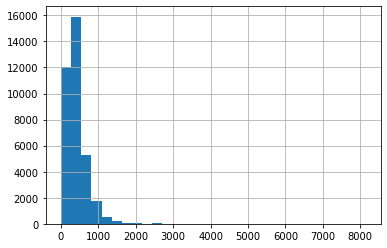

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
sum(seq_len) / len(seq_len)

406.43621582493455

In [ ]:
max_seq_len = 8

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
len(tokens_val['input_ids'][1])

8

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

print(f'shape of train val test set: {train_y.shape}, {val_y.shape}, {test_y.shape}')

shape of train val test set: torch.Size([35918]), torch.Size([4490]), torch.Size([4490])


# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.2)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW
from transformers import get_cosine_schedule_with_warmup

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# define the scheduler
#scheduler = get_cosine_schedule_with_warmup(optimizer, )

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.95602875 1.04821105]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

# Fine-Tune BERT

In [ ]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def topk_accuracy(k, outputs, targets):
    """
    Compute top k accuracy
    """
    batch_size = targets.size(0)

    _, pred = outputs.topk(k, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.type(torch.FloatTensor).sum().item()

    return n_correct_elems / batch_size


def top1_accuracy(outputs, targets):
    return topk_accuracy(1, outputs, targets)

In [ ]:
# function to train the model
def train():
  train_acc, val_acc, train_loss, val_loss = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('Batch {} of {}: loss {:.2f}, acc {:.5f}'.format(step, len(train_dataloader), train_loss.avg, train_acc.avg))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    train_loss.update(loss.item())

    acc = top1_accuracy(preds, labels)
    train_acc.update(acc)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  train_acc, val_acc, train_loss, val_loss = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('Batch {} of {}: loss {:.2f}, acc {:.5f}'.format(step, len(val_dataloader), val_loss.avg, val_acc.avg))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      val_loss.update(loss.item())

      acc = top1_accuracy(preds, labels)
      val_acc.update(acc)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    t_loss, _ = train()
    
    #evaluate model
    v_loss, _ = evaluate()
    
    #save the best model
    if v_loss < best_valid_loss:
        best_valid_loss = v_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(t_loss)
    valid_losses.append(v_loss)
    
    print(f'\nTraining Loss: {t_loss:.6f}')
    print(f'Validation Loss: {v_loss:.6f}')


 Epoch 1 / 5
Batch 50 of 1123: loss 0.37, acc 0.82937
Batch 100 of 1123: loss 0.29, acc 0.87187
Batch 150 of 1123: loss 0.24, acc 0.90125
Batch 200 of 1123: loss 0.20, acc 0.91859
Batch 250 of 1123: loss 0.18, acc 0.92875
Batch 300 of 1123: loss 0.16, acc 0.93604
Batch 350 of 1123: loss 0.15, acc 0.94161
Batch 400 of 1123: loss 0.14, acc 0.94398
Batch 450 of 1123: loss 0.14, acc 0.94764
Batch 500 of 1123: loss 0.13, acc 0.94956
Batch 550 of 1123: loss 0.13, acc 0.95222
Batch 600 of 1123: loss 0.13, acc 0.95271
Batch 650 of 1123: loss 0.12, acc 0.95486
Batch 700 of 1123: loss 0.12, acc 0.95603
Batch 750 of 1123: loss 0.12, acc 0.95742
Batch 800 of 1123: loss 0.11, acc 0.95859
Batch 850 of 1123: loss 0.11, acc 0.95989
Batch 900 of 1123: loss 0.11, acc 0.96122
Batch 950 of 1123: loss 0.10, acc 0.96230
Batch 1000 of 1123: loss 0.10, acc 0.96337
Batch 1050 of 1123: loss 0.10, acc 0.96417
Batch 1100 of 1123: loss 0.10, acc 0.96460

Evaluating...
Batch 50 of 141: loss 0.03, acc 0.99062
Batch

In [ ]:
# torch.save(model.state_dict(), '/content/drive/My Drive/CS3244/models/BERT_L64_0.041.pt')

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
test_seq[0]

tensor([  101,  2057,  2113,  2008,  7020, 11980,  2003,   102])

In [ ]:
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
total_preds, total_labels = [], []

for step, batch in enumerate(test_dataloader):
    if step % 50 == 0:
      print('Batch {} of {}'.format(step, len(test_dataloader)))
    
    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      preds = model(sent_id, mask).detach().cpu().numpy()
      total_preds.append(preds)
      total_labels.append(labels.detach().cpu().numpy())
    
  
total_preds = np.concatenate(total_preds, axis=0)
total_labels = np.concatenate(total_labels, axis=0)

Batch 0 of 141
Batch 50 of 141
Batch 100 of 141


In [ ]:
print(total_preds.shape, total_labels.shape)

(4490, 2) (4490,)


In [ ]:
# model's performance
preds = np.argmax(total_preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2348
           1       1.00      0.98      0.99      2142

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490



In [ ]:
print(f'accuracy {np.sum(np.array(preds) == np.array(test_y))/preds.shape[0]}')

accuracy 0.9922048997772829


In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,2346,2
1,33,2109


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/CS3244/models/BERT_L64_best.pt')